# The latest and greatest of using XGBoost to pair muons from an off-shell parent particle 
## Stephen D. Butalla
## 2022/10/10

In [1]:
from glob import glob
from utilities.utilities import *
from utilities.histUtilities import *
import joblib
import pandas as pd
import shutil
import json
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                             roc_auc_score, accuracy_score, jaccard_score)
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
import sys
from xgboost import XGBClassifier
sys.path.insert(0, "/Volumes/EASYSTORE/fD_model/utilities/")
from utilities.file_utils import *
import time
from tqdm import tqdm

global resultDir
resultDir = "dataframes"

plt.rcParams.update({'font.size': 32}) # Increase font size for plotting

global mZD_prefix
mZD_prefix = "MZD" 

#from MLtools.xgb_plusplus import *
#from MLtools.xgb import *
#from MLtools.xgb_roc import *
#from MLtools.neuralNetwork import *
#from MLtools.xgb_plots import *
#from MLtools.diMuonShape import *
#rom MLtools.diMuonBkg import *

/usr/local/lib/python3.10/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
def sort_dict(dictionary):
    sorted_dict = {}
    for mZD in dictionary.keys():
        temp_dict  = {int(sDmass): val for sDmass, val in dictionary[mZD].items()}
        temp_dict  = dict(sorted(temp_dict.items()))
        sorted_dict[mZD] = {str(sDmass): val for sDmass, val in temp_dict.items()}
    
    return sorted_dict

def remove_mass(dictionary, mass):
    mass_str = str(mass)
    for mZD in dictionary.keys():
        try:
            del dictionary[mZD][mass_str]
        except KeyError:
            print_alert("")
            print_error("Key error")
            print_alert("")
            pass
    
    return dictionary

In [3]:
with open("processed_root_files_mc/alt_csv_list.json", "r") as file:
    alt_csv_list_import = json.load(file)

In [4]:
all_dataframes = {}
for mZD in alt_csv_list_import.keys():
    all_dataframes[mZD] = {} 
    for msD in alt_csv_list_import[mZD].keys():
        if msD == "ALL" or alt_csv_list_import[mZD][msD] is None:
            continue
        else:
            all_dataframes[mZD][msD] = pd.read_csv(alt_csv_list_import[mZD][msD], usecols = ["selpT0", "selpT1", "selpT2", "selpT3", "selEta0", "selEta1", "selEta2", "selEta3",\
              "selPhi0", "selPhi1", "selPhi2", "selPhi3", "selCharge0", "selCharge1", "selCharge2", "selCharge3", "dPhi0", "dPhi1","dRA0", "dRA1", "event", "invMassA0",\
              "invMassA1", "pair"])

In [5]:
temp           = sort_dict(all_dataframes)
all_dataframes = temp
del temp

In [6]:
temp           = remove_mass(all_dataframes, int(10))
all_dataframes = temp
del temp


Key error


Key error


Key error


Key error



In [7]:
verbose = False
import warnings
warnings.filterwarnings("ignore") 

### Everything in a loop
plt.rcParams.update({'font.size': 32}) # Increase font size for plotting

base_dir = "processed_root_files_mc/"
save_fig = True

traintest_dict = {"validation_0": "Train", "validation_1": "Test"}
metric_dict    = {"logloss": "Log-loss", "error": "Error", "auc": "AUC"}
classes        = ["Negative", "Positive"]
types          = [['TP','FP'], ['FN', 'TN']]
classification = ["tn", "fp", "fn", "tp"]

## create dicts to store various metrics for later
acc_dict       = {} # dict for accuracies
jacc_dict      = {} # dict for jaccard score (not necessary, but interesting to have)
exec_time_dict = {} # dict for the execution time of each xgb training
class_rep_dict = {} # dict for classification report (f1 score pariticularly important)
confmat_dict   = {} # dict for confustion matrices
auc_dict       = {} # dict for areas under the curve
feat_import    = {} # dict for the feature importances

for mZD in all_dataframes.keys(): # loop over mZD
    ## create nested dicts
    acc_dict[mZD]       = {}
    jacc_dict[mZD]      = {}
    exec_time_dict[mZD] = {}
    class_rep_dict[mZD] = {}
    confmat_dict[mZD]   = {}
    auc_dict[mZD]       = {}
    feat_import[mZD]    = {}
    
    mZD_dir = "MZD_%s" % mZD # subdirectory (one under the basedir) for all mZD
    
    for msD in all_dataframes[mZD].keys():
        print_alert("Working on sample with mZD = %s and msD = %s" % (mZD, msD))
            
        full_path = base_dir + mZD_dir + "/" + (mZD_dir + "_%s/" % msD) # total path for saving results of individual samples
        
        ###########################################################################################################
        ###########################################################################################################
        ##                                            Data preprocessing                                         ##
        ###########################################################################################################
        ###########################################################################################################
        
        temp = all_dataframes[mZD][msD].to_numpy() # convert dict to numpy for splitting into train/test datasets

        X_data = temp[:, 0:23]              # features 
        Y_data = temp[:,   23].astype(int)  # event labels

        X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size = 0.7, random_state = 7) # split into 70/30 train/test datasets
        
        ## place the train and test datasets in dataframes
        trainX = pd.DataFrame(X_train, columns = ["selpT0", "selpT1", "selpT2", "selpT3", "selEta0", "selEta1", "selEta2", "selEta3",
          "selPhi0", "selPhi1", "selPhi2", "selPhi3", "selCharge0", "selCharge1", "selCharge2", "selCharge3", "dPhi0", "dPhi1","dRA0", "dRA1", "event", "invMassA0",
          "invMassA1"])
        testX  = pd.DataFrame(X_test, columns = ["selpT0", "selpT1", "selpT2", "selpT3", "selEta0", "selEta1", "selEta2", "selEta3",
          "selPhi0", "selPhi1", "selPhi2", "selPhi3", "selCharge0", "selCharge1", "selCharge2", "selCharge3", "dPhi0", "dPhi1","dRA0", "dRA1", "event", "invMassA0",
          "invMassA1"])

        trainY = pd.DataFrame(y_train, columns = ['pair'])
        testY  = pd.DataFrame(y_test,  columns = ['pair'])
        
        del X_data, Y_data

        ###########################################################################################################
        ###########################################################################################################
        ##                                      XGBoost training and predicting                                  ##
        ###########################################################################################################
        ###########################################################################################################
        
        model      = XGBClassifier(n_jobs = -1, random_state = 7) # build the classifier
        eval_set   = [(trainX, trainY), (testX, testY)]
        start_time = time.time()
        model.fit(trainX, trainY, eval_metric = ["logloss", "error", "auc"], eval_set = eval_set, verbose = verbose)
        end_time   = time.time()
        
        joblib.dump(model, full_path + "trained_model_MZD_%s_%s.sav" % (mZD, msD)) # save the trained model
        
        results    = model.evals_result()  # get results dictionary (contains metric information as function of epoch), used for plotting
        predictedY = model.predict(testX)  # make predictions for test data
        
        ###########################################################################################################
        ###########################################################################################################
        ##                                           Computation of Metrics                                      ##
        ###########################################################################################################
        ###########################################################################################################
        
        ## compute metrics
        accuracy     = accuracy_score(testY, predictedY) # compute the accuracy
        jaccard      = jaccard_score(testY, predictedY)  # compute the Jaccard similarity coefficient
        total_time   = end_time - start_time # calculate total time to execute
        class_report = classification_report(testY, predictedY, output_dict = True)
        
        if verbose:
            ## print summary of metrics
            print_alert("================================ Summary ================================")
            print_alert("Accuracy calculated using metrics.accuracy_score(): %.3f\n" % (accuracy * 100.0))                     # print accuracy to std out
            print_alert("Jaccard similarity coefficient calculated using metrics.jaccard_score(): %.3f\n" % (jaccard * 100.0)) # print Jaccard score to std out
            print_alert('\nTraining Classification Report:\n\n%s' % classification_report(testY, predictedY))                   # print accuracy to std out
            print_alert("Total model training time: %.2f\n\n" % total_time)                                                     # print total execution time to std out                                            
        
        ###########################################################################################################
        ##                                           Plot metrics vs. epoch                                      ##
        ###########################################################################################################
            
        valid_sets  = list(results.keys())
        metric_keys = list(results[valid_sets[0]].keys())
        x_axis      = np.arange(0, len(results['validation_0']['logloss'])) # create arang of epochs for plotting

        for key in metric_keys: # loop over metrics and plot (default: logloss, error, auc)
            fig, ax = plt.subplots(figsize = (12, 12))
            ax.grid(zorder = 0)
            for valid in valid_sets: # plot the training and validation (test) set results
                ax.plot(x_axis, results[valid][key], label = traintest_dict[valid])

            ax.legend()
            ax.set_xlabel('Epoch',  loc = "right")
            ax.set_ylabel('%s' % metric_dict[key], loc = "top")

            fig.tight_layout()
            if save_fig:
                fig.savefig(full_path + "%s_MZD_%s_%s.pdf" % (key, mZD, msD))
                plt.close()

        fig, ax = plt.subplots(1, 3, figsize = (20, 10)) # create grid of plots
        ax.ravel() # unravel directory
        for metric, plot in zip(metric_dict, range(len(metric_dict))):
            for valid in valid_sets:
                ax[plot].plot(x_axis, results[valid][metric], label = traintest_dict[valid])

            ax[plot].grid(zorder = 0)
            ax[plot].legend()
            ax[plot].set_xlabel('Epoch',  loc = "right")
            ax[plot].set_ylabel('%s' % metric_dict[metric], loc = "top")

        fig.tight_layout()
        fig.suptitle("XGBoost metrics")
        fig.subplots_adjust(top = 0.9)  # properly space title and tops of plots

        if save_fig:
            fig.savefig(full_path + "all_plots_MZD_%s_%s.pdf" % (mZD, msD))
            plt.close()
        
        del fig, ax
        
        ###########################################################################################################
        ##                                             Confusion matrix                                          ##
        ###########################################################################################################
        
        tn, fp, fn, tp = confusion_matrix(testY, predictedY).ravel()
        conf_mat       = [[int(tp), int(fp)], [int(fn), int(tn)]] # must convert to python built-in int and not np int64 (int64 not serializable to json) 
        fig, ax        = plt.subplots(figsize = (12, 12))  
        im             = ax.imshow(conf_mat, interpolation = 'nearest', cmap = plt.cm.winter)
        cbar           = fig.colorbar(im, fraction = 0.0458, pad = 0.04, label = "Number classifications")
        ax.set_title("Confusion matrix")
        ax.set_xticks([])
        ax.set_yticks([])
        
        ## place text labels of the TP, FP, FN, TN
        for ii in range(2):
            for jj in range(2):
                plt.text(jj - 0.2, ii, "%s = %d" % (types[ii][jj], conf_mat[ii][jj]), fontsize = 30)

        fig.tight_layout()
        if save_fig:
            fig.savefig(full_path + "confusion_matrix_MZD_%s_%s.pdf" % (mZD, msD))
            plt.close()
        
        del fig, ax
        ###########################################################################################################
        ##                                                 ROC/AUC                                               ##
        ###########################################################################################################
        
        ns_probs  = np.zeros(len(testY), dtype = int) # initialize array of probabilities for a classifier with no skill
        mod_probs = model.predict_proba(testX)        # predict probabilities
        mod_probs = mod_probs[:, 1]                   # keep probabilities for positive outcome only

        ## calculate scores for ROC and AUC
        ns_auc  = roc_auc_score(testY, ns_probs)   # no-skill AUC
        mod_auc = roc_auc_score(testY, mod_probs)  # model (logistic) AUC

        ## summarize ROC with the area under the curve (AUC)
        if verbose:
            print('No Skill: AUC = %.3f' % (ns_auc))
            print('Logistic: AUC = %.3f' % (mod_auc))

        ## generate roc curves
        ns_fpr, ns_tpr, _   = roc_curve(testY, ns_probs)
        mod_fpr, mod_tpr, _ = roc_curve(testY, mod_probs)

        ## make a pretty plot
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.grid(zorder = 0)
        ax.plot(ns_fpr, ns_tpr, linestyle = '--', color = 'tab:red', label = 'No Skill')
        ax.plot(mod_fpr, mod_tpr, marker = '.', color = 'tab:blue', label = 'Logistic')
        ax.set_xlabel('False Positive Rate', loc = 'right')
        ax.set_ylabel('True Positive Rate', loc = 'top')
        ax.legend()
        textstr = '\n'.join((
            'No skill AUC = %.3f' % (ns_auc, ),
            'Model AUC = %.3f' %   (mod_auc, )))

        props = dict(boxstyle = 'round', facecolor = 'white', alpha = 0.5)

        ax.text(0.5, 0.3, textstr, transform = ax.transAxes, fontsize = 26, verticalalignment = 'top', bbox = props)
        fig.tight_layout()

        if save_fig:
            fig.savefig(full_path + ("roc_auc_MZD_%s_%s.pdf" % (mZD, msD)))
            plt.close()
        
        del fig, ax
        ###########################################################################################################
        ##                                              Feature importances                                      ##
        ###########################################################################################################
            
        x_tick_labels       = list(testX.columns)
        feature_import      = model.feature_importances_
        feature_import_dict = {label: value for label, value in zip(x_tick_labels, feature_import)}
        sorted_features     = {var: float(val) for var, val in sorted(feature_import_dict.items(), key = lambda item: item[1])} # sort by increasing feature importance
        sorted_feature_vals = sorted_features.values()
        xaxis_vals          = np.arange( len(x_tick_labels))
        
        ## plot feature importances
        fig, ax = plt.subplots(figsize = (20, 12))
        ax.grid(zorder = 0)
        ax.bar(xaxis_vals, sorted_feature_vals, width = 0.6, zorder = 3)
        ax.set_xticklabels(x_tick_labels, rotation = 60, fontsize = 19)
        ax.set_xticks(xaxis_vals)
        ax.set_xlabel("Feature", loc = "right")
        ax.set_ylabel("Importance", loc = "top")
        xlocs = ax.get_xticks() # get x-axis location of each bar 
        for idx, val in enumerate(sorted_feature_vals): # place text of bar value over each bar
            ax.text(xlocs[idx] - 0.4, val + 0.01, "%.2f" % val, fontsize = 16)
        
        fig.tight_layout()

        if save_fig:
            fig.savefig(full_path + ("feature_importance_MZD_%s_%s.pdf" % (mZD, msD)))
            plt.close()
        
        del fig, ax
        ###########################################################################################################
        ##                                       Prepare dictionaries for saving                                 ##
        ###########################################################################################################
        
        sample_acc_dict       = {"accuracy": accuracy}
        sample_jacc_dict      = {"jaccard": jaccard}
        sample_exec_time_dict = {"exectime": total_time}
        sample_confmat_dict   = {"tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn)}
        sample_auc_dict       = {"auc": mod_auc}
        
        ###########################################################################################################
        ##                                     Save dictionaries to local files                                  ##
        ###########################################################################################################
        
        with open(full_path + ("accuracy_MZD_%s_%s.json" % (mZD, msD)), "w") as file:
            json.dump(sample_acc_dict, file)
            
        with open(full_path + ("jaccard_MZD_%s_%s.json" % (mZD, msD)), "w") as file:
            json.dump(sample_jacc_dict, file)
            
        with open(full_path + ("exec_time_MZD_%s_%s.json" % (mZD, msD)), "w") as file:
            json.dump(sample_exec_time_dict, file)
        
        with open(full_path + ("classification_report_MZD_%s_%s.json" % (mZD, msD)), "w") as file:
            json.dump(class_report, file)
        
        with open(full_path + ("confusion_matrix_MZD_%s_%s.json" % (mZD, msD)), "w") as file:
            json.dump(sample_confmat_dict, file)
        
        with open(full_path + ("auc_MZD_%s_%s.json" % (mZD, msD)), "w") as file:
            json.dump(sample_auc_dict, file)
        
        with open(full_path + ("feature_importances_MZD_%s_%s.json" % (mZD, msD)), "w") as file:
            json.dump(sorted_features, file)
            
        with open(full_path + ("results_dict_MZD_%s_%s.json" % (mZD, msD)), "w") as file:
            json.dump(results, file)
            
        ###########################################################################################################
        ##                                     Save values to various dictionaries                               ##
        ########################################################################################################### 
        
        ## store all of the metrics in the various dicts
        acc_dict[mZD][msD]       = accuracy            # store accuracy in dict
        jacc_dict[mZD][msD]      = jaccard             # store jaccard score in dict
        exec_time_dict[mZD][msD] = total_time          # store execution time in dict
        class_rep_dict[mZD][msD] = class_report        # store entire classification report in dict 
        confmat_dict[mZD][msD]   = sample_confmat_dict # store confusion matrix in dict
        auc_dict[mZD][msD]       = mod_auc             # store AUC in dict
        feat_import[mZD][msD]    = sorted_features     # 
        

Working on sample with mZD = 85 and msD = 5
Working on sample with mZD = 85 and msD = 15
Working on sample with mZD = 85 and msD = 20
Working on sample with mZD = 85 and msD = 25
Working on sample with mZD = 85 and msD = 35
Working on sample with mZD = 95 and msD = 5
Working on sample with mZD = 95 and msD = 15
Working on sample with mZD = 95 and msD = 25
Working on sample with mZD = 95 and msD = 30
Working on sample with mZD = 95 and msD = 35
Working on sample with mZD = 95 and msD = 40
Working on sample with mZD = 95 and msD = 45
Working on sample with mZD = 125 and msD = 5
Working on sample with mZD = 125 and msD = 15
Working on sample with mZD = 125 and msD = 20
Working on sample with mZD = 125 and msD = 25
Working on sample with mZD = 125 and msD = 30
Working on sample with mZD = 125 and msD = 35
Working on sample with mZD = 125 and msD = 40
Working on sample with mZD = 125 and msD = 45
Working on sample with mZD = 125 and msD = 50
Working on sample with mZD = 125 and msD = 55
Wor

In [8]:
with open("processed_root_files_mc/all_metrics/all_accuracy.json", "w") as file:
    json.dump(acc_dict, file)
            
with open("processed_root_files_mc/all_metrics/all_jaccard.json", "w") as file:
    json.dump(jacc_dict, file)

with open("processed_root_files_mc/all_metrics/all_exec_time.json", "w") as file:
    json.dump(exec_time_dict, file)

with open("processed_root_files_mc/all_metrics/all_classification_report.json", "w") as file:
    json.dump(class_rep_dict, file)

with open("processed_root_files_mc/all_metrics/all_confusion_matrix.json", "w") as file:
    json.dump(confmat_dict, file)

with open("processed_root_files_mc/all_metrics/all_auc.json", "w") as file:
    json.dump(auc_dict, file)

with open("processed_root_files_mc/all_metrics/all_feature_importances.json", "w") as file:
    json.dump(feat_import, file)

In [9]:
del acc_dict, jacc_dict, exec_time_dict, class_rep_dict
del confmat_dict, auc_dict, feat_import

In [10]:
with open("processed_root_files_mc/all_metrics/all_accuracy.json", "r") as file:
    acc_dict = json.load(file)
            
with open("processed_root_files_mc/all_metrics/all_jaccard.json", "r") as file:
    jacc_dict = json.load(file)

with open("processed_root_files_mc/all_metrics/all_exec_time.json", "r") as file:
    exec_time_dict = json.load(file)

with open("processed_root_files_mc/all_metrics/all_classification_report.json", "r") as file:
    class_rep_dict = json.load(file)

with open("processed_root_files_mc/all_metrics/all_confusion_matrix.json", "r") as file:
    confmat_dict = json.load(file)

with open("processed_root_files_mc/all_metrics/all_auc.json", "r") as file:
    auc_dict = json.load(file)

with open("processed_root_files_mc/all_metrics/all_feature_importances.json", "r") as file:
    feat_import = json.load(file)

In [11]:
metrics = {"acc": acc_dict, "jacc": jacc_dict, "time": exec_time_dict, "clrep": class_rep_dict, "confmat": confmat_dict, "auc": auc_dict, "feat": feat_import}

In [12]:
sorted_metrics = {}
for metric in metrics.keys():
    sorted_metrics[metric] = sort_dict(metrics[metric])

In [84]:
class_rep_dict

{'85': {'5': {'0': {'precision': 1.0,
    'recall': 0.9988833054159687,
    'f1-score': 0.9994413407821229,
    'support': 1791},
   '1': {'precision': 0.9978331527627302,
    'recall': 1.0,
    'f1-score': 0.9989154013015185,
    'support': 921},
   'accuracy': 0.9992625368731564,
   'macro avg': {'precision': 0.9989165763813651,
    'recall': 0.9994416527079844,
    'f1-score': 0.9991783710418207,
    'support': 2712},
   'weighted avg': {'precision': 0.9992641348430953,
    'recall': 0.9992625368731564,
    'f1-score': 0.9992627308036434,
    'support': 2712}},
  '15': {'0': {'precision': 0.9963065558633426,
    'recall': 0.9967667436489608,
    'f1-score': 0.9965365966289541,
    'support': 2165},
   '1': {'precision': 0.9937444146559428,
    'recall': 0.9928571428571429,
    'f1-score': 0.9933005806163465,
    'support': 1120},
   'accuracy': 0.9954337899543378,
   'macro avg': {'precision': 0.9950254852596427,
    'recall': 0.9948119432530518,
    'f1-score': 0.9949185886226504,


In [13]:
precision = {}
recall    = {}
f1_score  = {}
for mZD in sorted_metrics['clrep'].keys():
    precision[mZD] = {}
    recall[mZD]    = {}
    f1_score[mZD]  = {}
    for msD in sorted_metrics['clrep'][mZD].keys():
        precision[mZD][msD] = {}
        recall[mZD][msD]    = {}
        f1_score[mZD][msD]  = {}
        for event_type in np.arange(2):
            precision[mZD][msD][str(event_type)] = class_rep_dict[mZD][msD][str(event_type)]['precision']
            recall[mZD][msD][str(event_type)]    = class_rep_dict[mZD][msD][str(event_type)]['recall']
            f1_score[mZD][msD][str(event_type)]  = class_rep_dict[mZD][msD][str(event_type)]['f1-score']

In [14]:
sorted_acc_dict = {}
for mZD in acc_dict.keys():
    temp_dict  = {int(sDmass): val for sDmass, val in acc_dict[mZD].items()}
    temp_dict  = dict(sorted(temp_dict.items()))
    sorted_acc_dict[mZD] = {str(sDmass): val for sDmass, val in temp_dict.items()}

In [15]:
acc_dict_reduced  = remove_mass(sorted_acc_dict, int(10))
precision_reduced = remove_mass(precision, int(10))
recall_reduced    = remove_mass(recall, int(10))
f1_score_reduced  = remove_mass(f1_score, int(10))


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error


Key error



In [16]:
num_sD = [len(acc_dict_reduced[mZD]) for mZD in acc_dict_reduced.keys()]
max_sD = max(num_sD)
num_ZD = len(acc_dict_reduced.keys())

In [17]:
acc_map = np.zeros((num_ZD, max_sD)) # rows = num_mZD 

In [18]:
for mZD, zd_index in zip(acc_dict_reduced.keys(), np.arange(len(acc_dict_reduced.keys()))):
    #print("mzd = %s" %  mZD)
    #print("ZD index = %s" % zd_index)
    temp = [val for sDmass, val in acc_dict_reduced[mZD].items()]
    #print("temp = ", temp)
    #print("len(temp = )", len(temp))
    indices = np.arange(len(temp))
    #print("np.arange(len(temp)) = ", indices)
    for val, sd_index in zip(temp, np.arange(len(temp))):
        #print("value = %f" % val  )
        #print("sD index = %s" % sd_index)
        acc_map[zd_index, sd_index] = val

In [19]:
total_sD_masses = np.array([5, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
total_ZD_masses = [int(mass) for mass in acc_dict_reduced.keys()]
total_ZD_masses = np.array(total_ZD_masses)

In [20]:
plt.rcParams.update({'font.size': 32}) # Increase font size for plotting

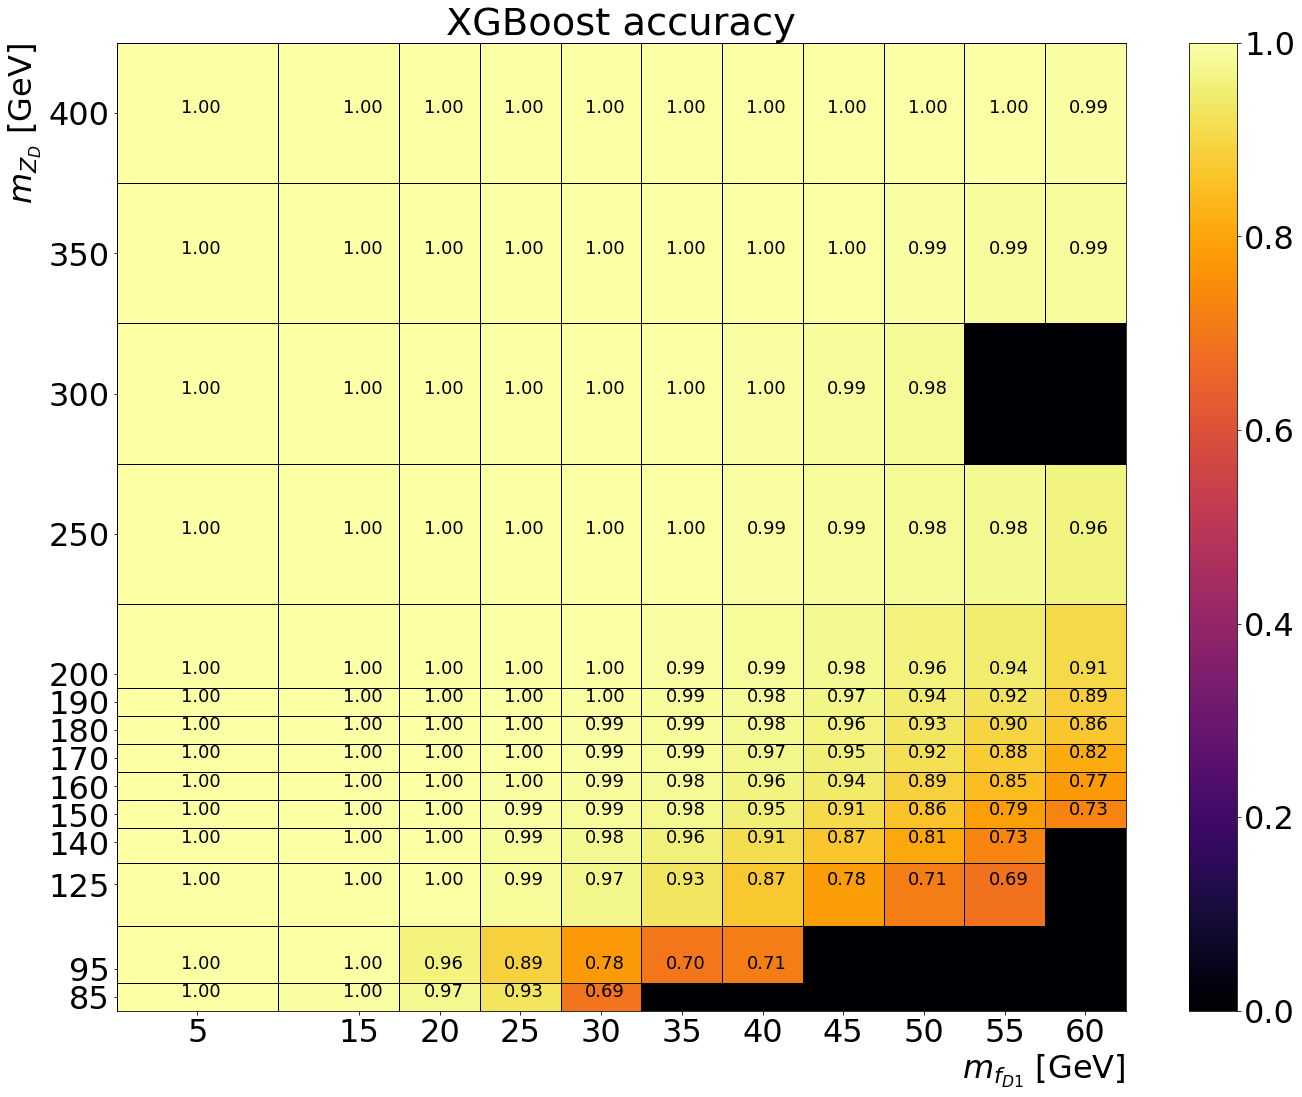

In [22]:
custom_xticks = sorted_acc_dict['400'].keys()
custom_xticks = [int(val) for val in custom_xticks]
custom_yticks = sorted_acc_dict.keys()
custom_yticks = [int(val) for val in custom_yticks]

fig, ax = plt.subplots(figsize = (20, 16))
#ax.imshow(acc_map, origin = "lower", extent = [5, 60, b, t])
#mesh = ax.pcolormesh(total_sD_masses, total_ZD_masses, acc_map, edgecolors='k', linewidths=0.5, cmap = 'inferno')
mesh = ax.pcolormesh(total_sD_masses, total_ZD_masses, acc_map, edgecolors='k', linewidths=0.5, cmap = 'inferno')
#ax.set_xticks(total_sD_masses[:-1]+1)
#ax.set_yticks(total_ZD_masses[:-1]+1)
cbar = plt.colorbar(mesh)
ax.set_xticks(custom_xticks)
ax.set_yticks(custom_yticks)
#ax.axis([total_sD_masses.min(), total_sD_masses.max(), total_ZD_masses.min(), total_ZD_masses.max()])
ax.set_xlabel(r'$m_{f_{D1}}$ [GeV]', loc = "right")
ax.set_ylabel(r'$m_{Z_{D}}$ [GeV]', loc = "top")
ax.set_title("XGBoost accuracy")

for mZD, zd_cnt in zip(acc_dict_reduced.keys(), np.arange(len(acc_dict_reduced.keys()))):
    for msD, sd_cnt in zip(acc_dict_reduced[mZD].keys(), np.arange(len(acc_dict_reduced[mZD].keys()))):
        
        ax.text(total_sD_masses[sd_cnt] - 1, total_ZD_masses[zd_cnt], "%.2f" % acc_map[zd_cnt, sd_cnt], fontsize = 18) #, ha = "center", va = "center")
        
fig.tight_layout()

fig.savefig("processed_root_files_mc/all_metrics/xgb_accuracy_all_samples.pdf")
#ax.set_xticklabels(custom_xticks, fontsize = 19)


In [23]:
precision_map = np.zeros((2, num_ZD, max_sD)) # rows = num_mZD 
recall_map    = np.zeros((2, num_ZD, max_sD)) # rows = num_mZD 
f1_score_map  = np.zeros((2, num_ZD, max_sD)) # rows = num_mZD 


for mZD, zd_index in zip(precision_reduced.keys(), np.arange(len(precision_reduced.keys()))):
    #print("mzd = %s" %  mZD)
    #print("ZD index = %s" % zd_index)
    temp_precision = [val for sDmass, val in precision_reduced[mZD].items()]
    temp_recall    = [val for sDmass, val in recall_reduced[mZD].items()]
    temp_f1score   = [val for sDmass, val in f1_score_reduced[mZD].items()]
    
    for val, sd_index in zip(temp_precision, np.arange(len(temp_precision))):
        #print("val = ", val)
        for key, class_index in zip(val.keys(), np.arange(len(val.keys()))):
            #print("key = %s" % key)
            #print("sD index = %s" % sd_index)
            precision_map[class_index, zd_index, sd_index] = val[key]
            
    for val, sd_index in zip(temp_recall, np.arange(len(temp_recall))):
        #print("val = ", val)
        for key, class_index in zip(val.keys(), np.arange(len(val.keys()))):
            #print("key = %s" % key)
            #print("sD index = %s" % sd_index)
            recall_map[class_index, zd_index, sd_index] = val[key]
    
    for val, sd_index in zip(temp_f1score, np.arange(len(temp_f1score))):
        #print("val = ", val)
        for key, class_index in zip(val.keys(), np.arange(len(val.keys()))):
            #print("key = %s" % key)
            #print("sD index = %s" % sd_index)
            f1_score_map[class_index, zd_index, sd_index] = val[key]
            

In [74]:
class_rep_dicts  = {"pre": precision, "recall": recall_reduced, "f1": f1_score_reduced}
class_rep_maps   = {"pre": precision_map, "recall": recall_map, "f1": f1_score_map}
class_rep_titles = {"pre": "precision", "recall": "recall", "f1": r'$F_{1}$ score'}

NameError: name 'precision_reduced' is not defined

In [25]:
classifications = list(precision_reduced['170']['15'].keys())

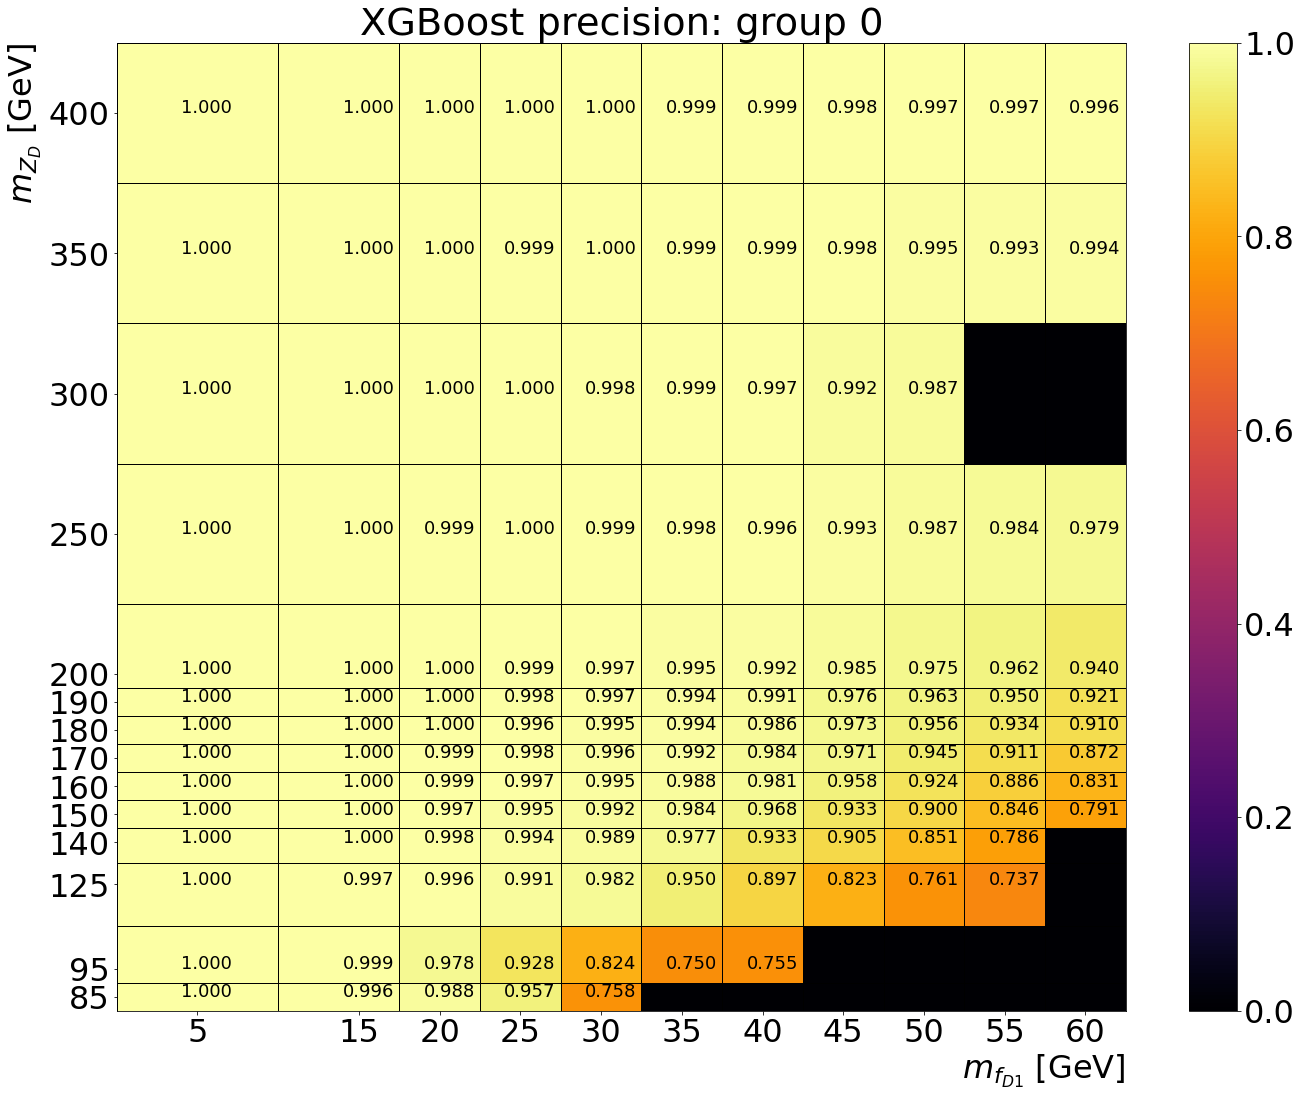

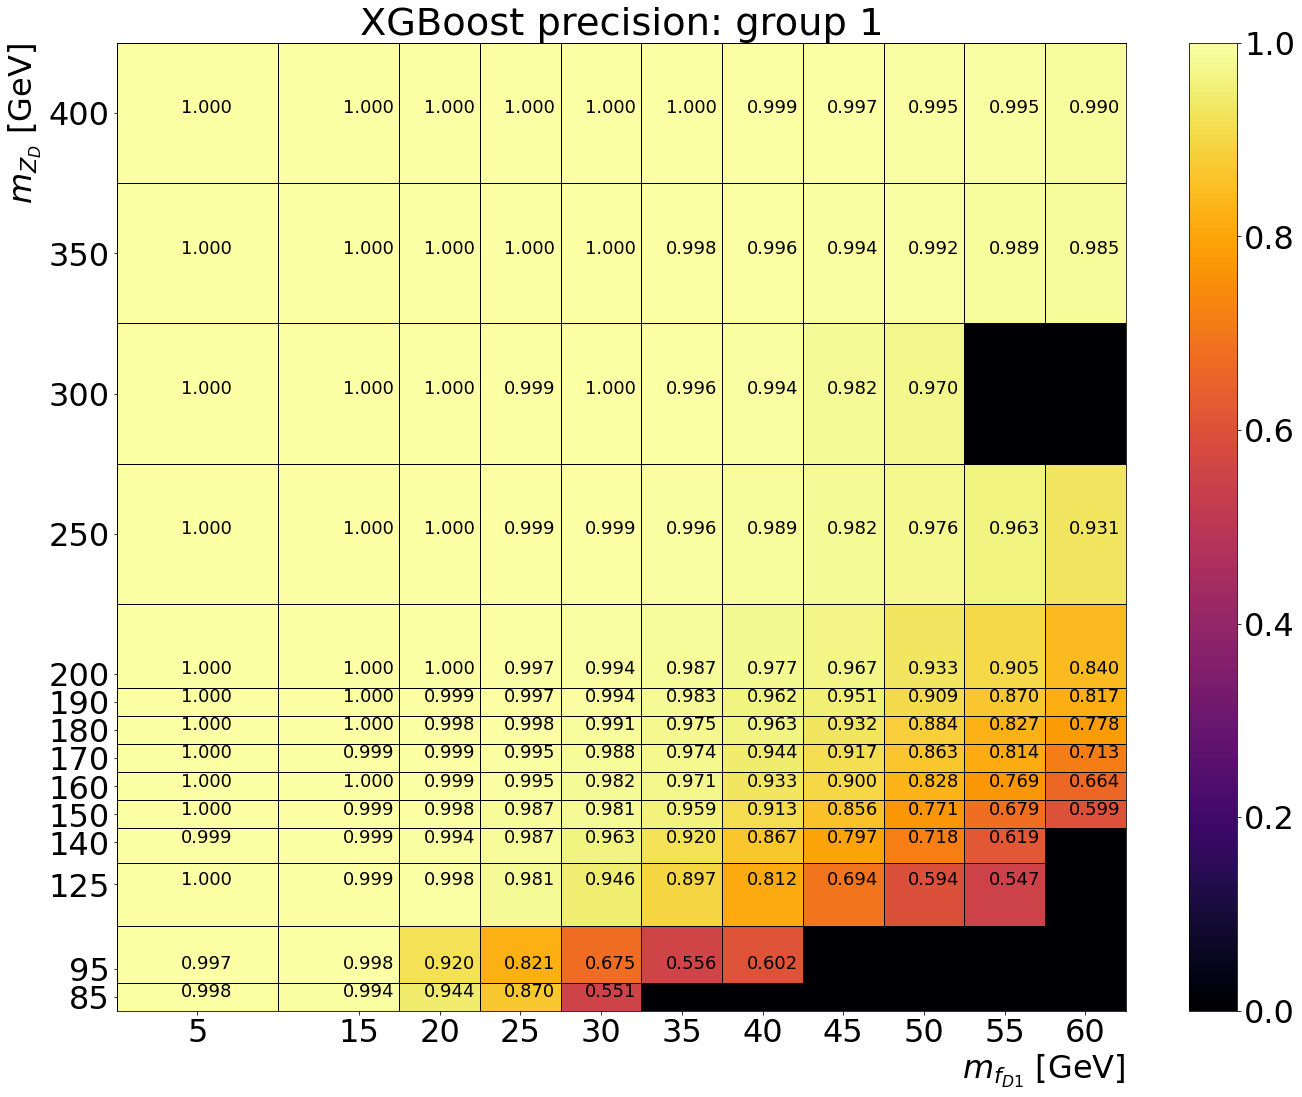

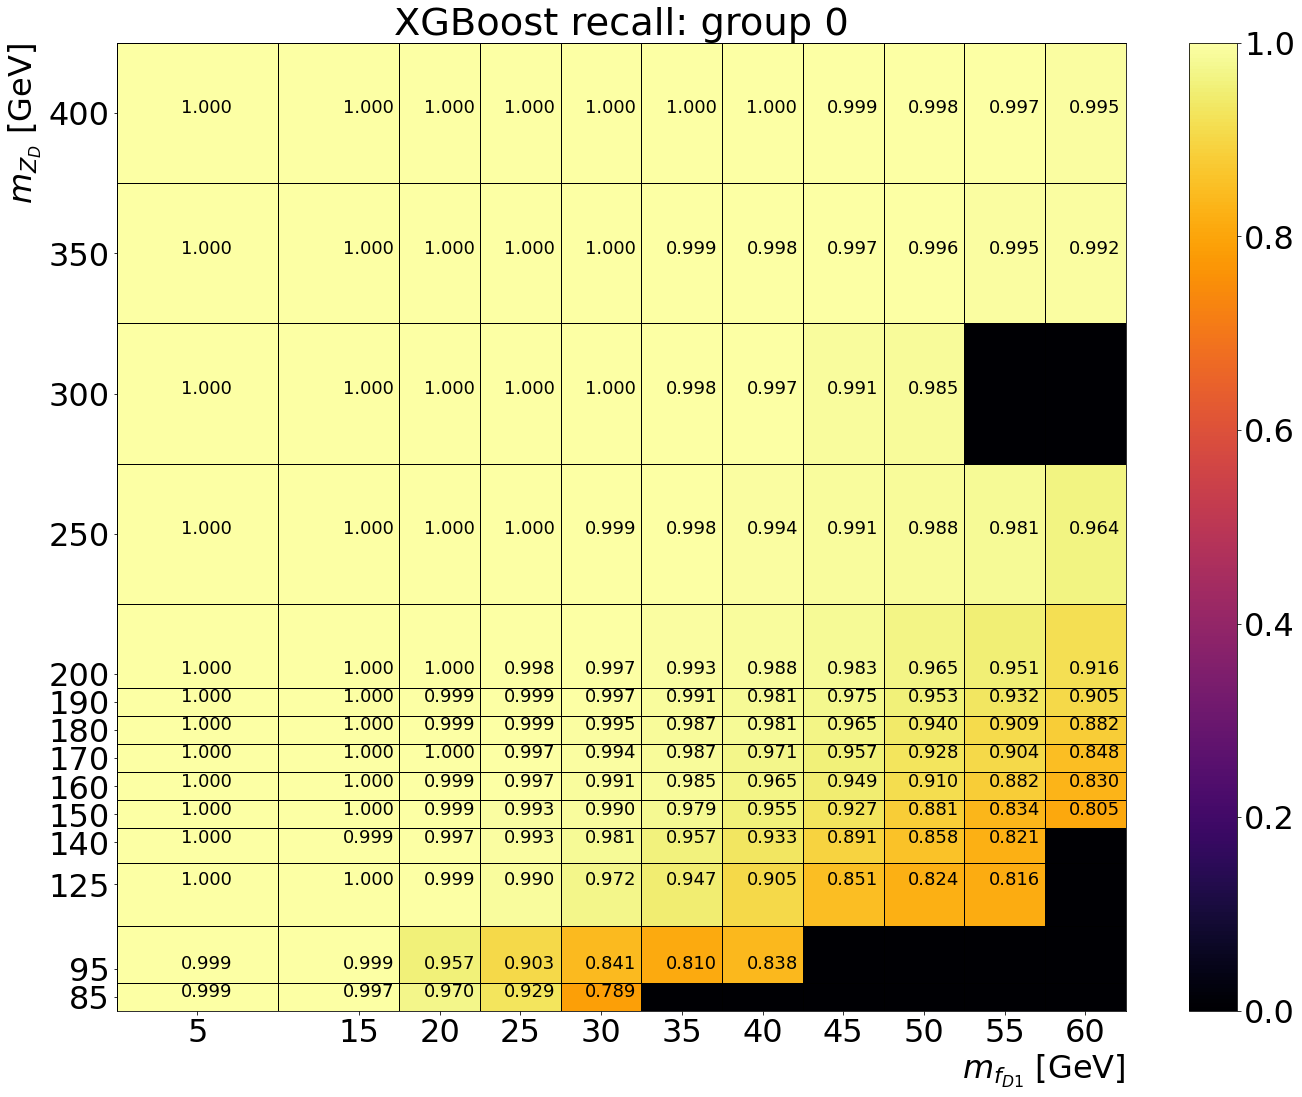

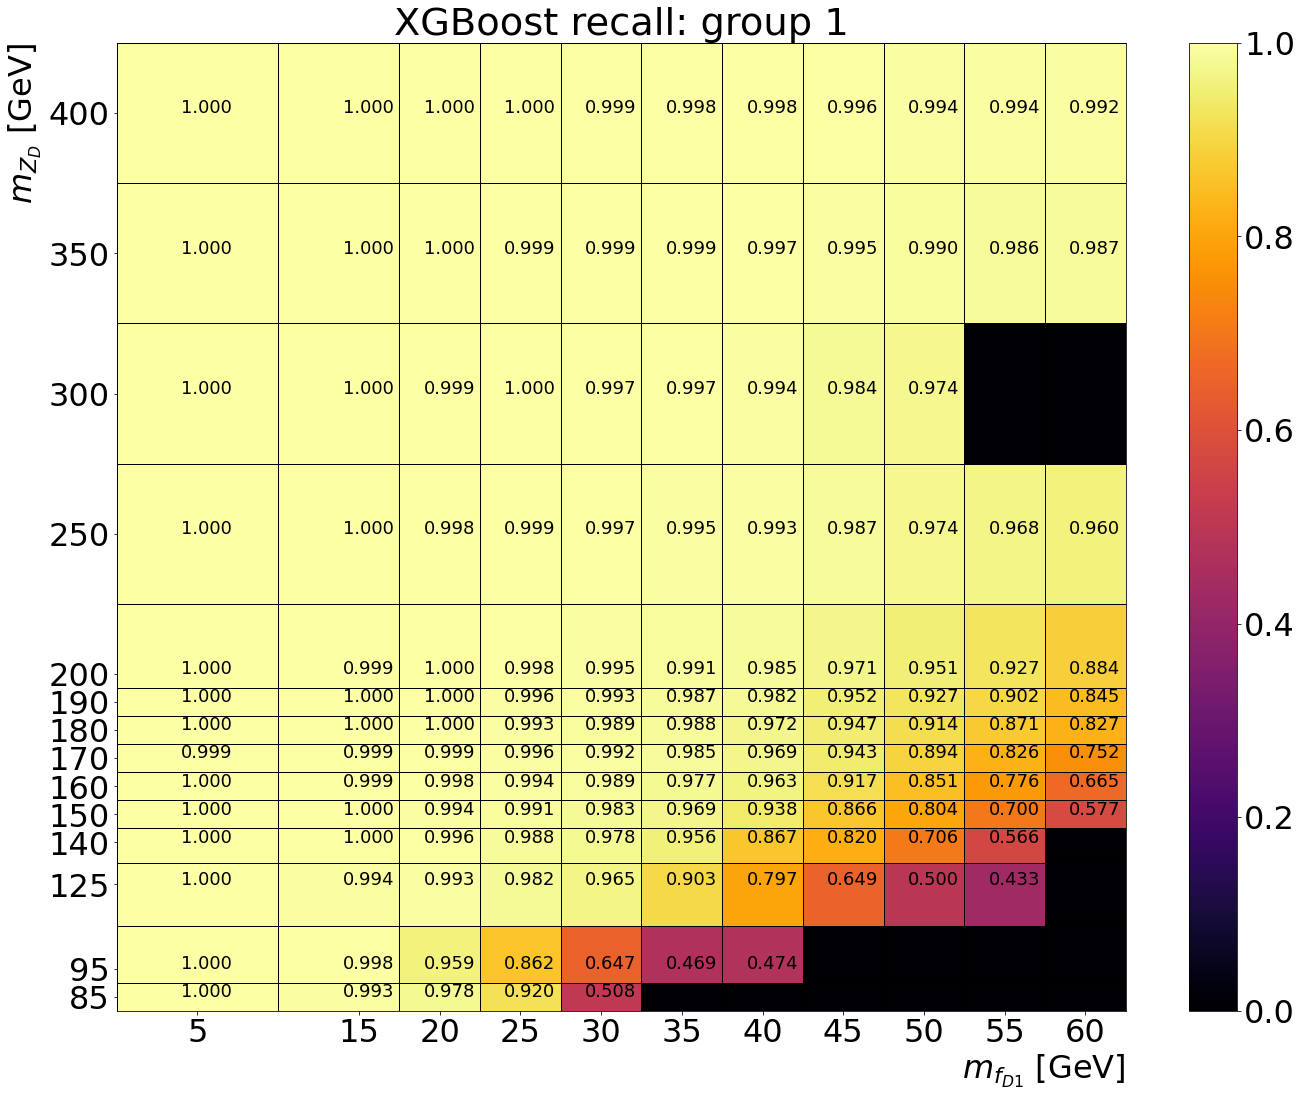

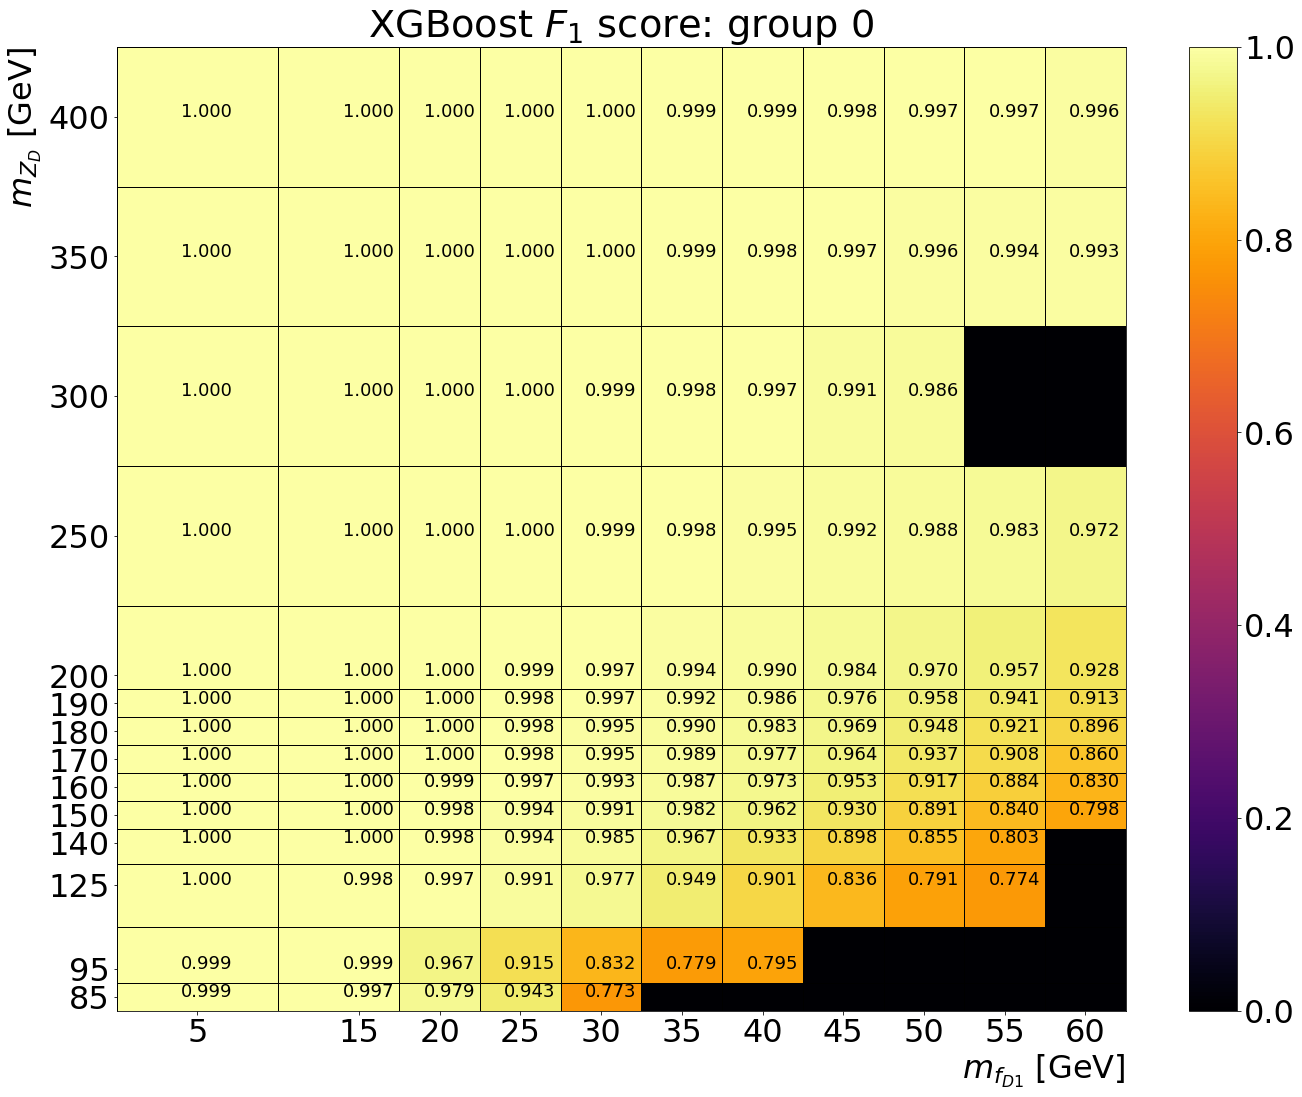

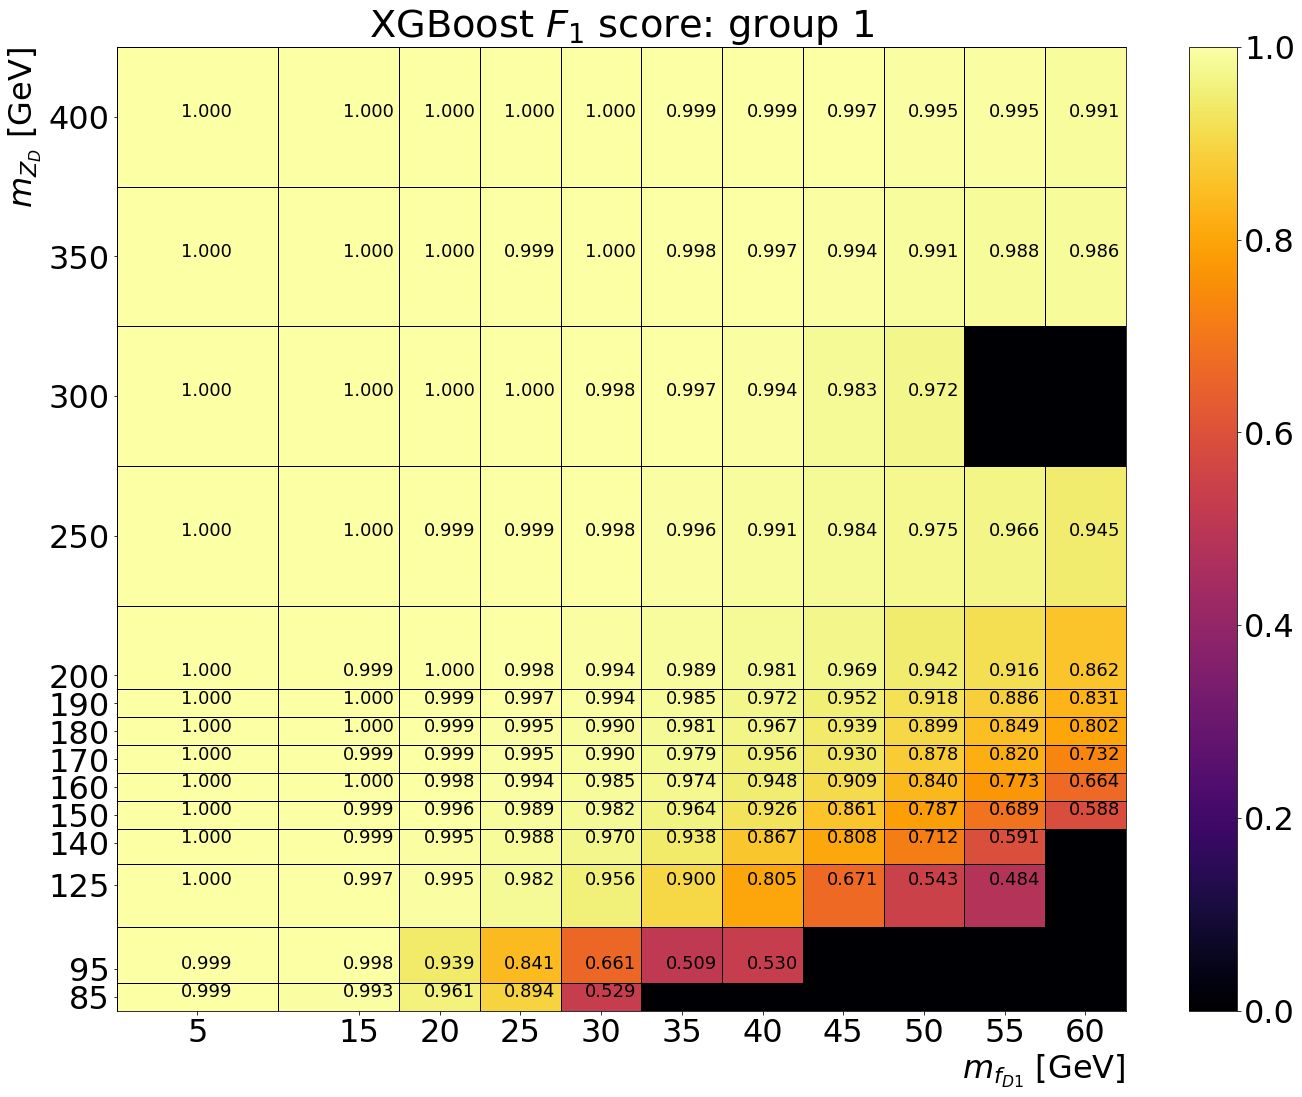

In [26]:
#custom_xticks = sorted_acc_dict['400'].keys()
#custom_xticks = [int(val) for val in custom_xticks]
#custom_yticks = sorted_acc_dict.keys()
#custom_yticks = [int(val) for val in custom_yticks]


#total_sD_masses = np.array([5, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
#total_ZD_masses = [int(mass) for mass in acc_dict_reduced.keys()]
#total_ZD_massetotal_ZD_massesrray(total_ZD_masses)

for key in class_rep_maps.keys(): # loop over precision, recall, f1 score
    for classification, class_index in zip(classifications, np.arange(len(classifications))): # loop over binary group choice: 0, 1
        fig, ax = plt.subplots(figsize = (20, 16))
        #ax.imshow(acc_map, origin = "lower", extent = [5, 60, b, t])
        #mesh = ax.pcolormesh(total_sD_masses, total_ZD_masses, acc_map, edgecolors='k', linewidths=0.5, cmap = 'inferno')
        mesh = ax.pcolormesh(total_sD_masses, total_ZD_masses, class_rep_maps[key][class_index], edgecolors = 'k', linewidths = 0.5, cmap = 'inferno')
        cbar = plt.colorbar(mesh)
        ax.set_xticks(custom_xticks)
        ax.set_yticks(custom_yticks)
        #ax.axis([total_sD_masses.min(), total_sD_masses.max(), total_ZD_masses.min(), total_ZD_masses.max()])
        ax.set_xlabel(r'$m_{f_{D1}}$ [GeV]', loc = "right")
        ax.set_ylabel(r'$m_{Z_{D}}$ [GeV]', loc = "top")
        ax.set_title(r'XGBoost %s: group %d' % (class_rep_titles[key], class_index))

        for mZD, zd_cnt in zip(acc_dict_reduced.keys(), np.arange(len(acc_dict_reduced.keys()))):
            for msD, sd_cnt in zip(acc_dict_reduced[mZD].keys(), np.arange(len(acc_dict_reduced[mZD].keys()))):
                ax.text(total_sD_masses[sd_cnt] - 1, total_ZD_masses[zd_cnt], "%.3f" % class_rep_maps[key][class_index, zd_cnt, sd_cnt], fontsize = 18) #, ha = "center", va = "center")

        fig.tight_layout()
        fig.savefig("processed_root_files_mc/all_metrics/class_report_maps_%s_group_%d_all_samples.pdf" % (key, class_index))

In [27]:
del acc_dict, jacc_dict, exec_time_dict, class_rep_dict, confmat_dict, auc_dict, feat_import

In [28]:
del metrics

In [2]:
with open("processed_root_files_mc/alt_csv_list.json", "r") as file:
    alt_csv_list_import = json.load(file)

all_dataframes = {}
for mZD in alt_csv_list_import.keys():
    all_dataframes[mZD] = {} 
    for msD in alt_csv_list_import[mZD].keys():
        if msD == "ALL" or alt_csv_list_import[mZD][msD] is None:
            continue
        else:
            all_dataframes[mZD][msD] = pd.read_csv(alt_csv_list_import[mZD][msD], usecols = ["selpT0", "selpT1", "selpT2", "selpT3", "selEta0", "selEta1", "selEta2", "selEta3",\
              "selPhi0", "selPhi1", "selPhi2", "selPhi3", "selCharge0", "selCharge1", "selCharge2", "selCharge3", "dPhi0", "dPhi1","dRA0", "dRA1", "event", "invMassA0",\
              "invMassA1", "pair"])

In [5]:
dataframe_keys_sorted  = {} 
all_dataframes_sorted  = sort_dict(all_dataframes)
all_dataframes_reduced = remove_mass(all_dataframes_sorted, int(10)) # remove 10 GeV
## dataframes for predicting with saved model files
all_dataframes_correct = {}
for mZD in all_dataframes_reduced.keys(): # loop over mZD
    all_dataframes_correct[mZD] = {}
    dataframe_keys_sorted[mZD]  = {}
    for msD in all_dataframes_reduced[mZD].keys():
        temp = all_dataframes_reduced[mZD][msD]
        all_dataframes_correct[mZD][msD] = temp[temp.pair != 0]
        dataframe_keys_sorted[mZD][msD] = None


Key error


Key error


Key error


Key error



In [25]:
with open("processed_root_files_mc/dataframe_keys_sorted.json", "w") as file:
    json.dump(dataframe_keys_sorted, file)

In [20]:
del all_dataframes, all_dataframes_sorted, all_dataframes_reduced

In [6]:
base_dir = "processed_root_files_mc/"
trained_models = {}
for mZD in all_dataframes_correct.keys():
    mZD_dir = "MZD_%s" % mZD
    print(mZD_dir)
    for msD in all_dataframes_correct[mZD].keys():
        key = mZD_dir + "_%s" % msD
        full_path = base_dir + mZD_dir + "/" + key # total path where trained model files are stored
        trained_models[key] = joblib.load(full_path + "/trained_model_%s.sav" % key)

MZD_85
MZD_95
MZD_125
MZD_140
MZD_150
MZD_160
MZD_170
MZD_180
MZD_190
MZD_200
MZD_250
MZD_300
MZD_350
MZD_400


In [3]:
num_models = len(class_report_all.keys())
num_sD     = [len(class_report_all['MZD_250_55'][mZD]) for mZD in class_report_all['MZD_250_55'].keys()]
max_sD     = max(num_sD)
total_sD_masses = np.array([5, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
total_ZD_masses = [int(mass) for mass in class_report_all['MZD_250_55'].keys()]
total_ZD_masses = np.array(total_ZD_masses)
num_ZD = len(total_ZD_masses)

In [4]:
all_models_metrics = {}

for model, model_index in zip(class_report_all.keys(), np.arange(len(class_report_all.keys()))):
    all_models_metrics[model] = {}
    
    accuracy_map  = np.full((num_ZD, max_sD), np.nan) # rows = num_mZD
    precision_map = np.full((num_ZD, max_sD), np.nan) # rows = num_mZD 
    recall_map    = np.full((num_ZD, max_sD), np.nan) # rows = num_mZD 
    f1_score_map  = np.full((num_ZD, max_sD), np.nan) # rows = num_mZD 

    for mZD, zd_index in zip(class_report_all[model].keys(), np.arange(len(class_report_all[model].keys()))):
        #print("mzd = %s" %  mZD)
        #print("ZD index = %s" % zd_index)
        for msD, sD_index in zip(class_report_all[model][mZD].keys(), np.arange(len(class_report_all[model][mZD].keys()))):
            sample_pred = "MZD_%s_%s" % (mZD, msD)
                        
            accuracy_map[zd_index, sD_index]  = accuracies_all[model][mZD][msD]
            precision_map[zd_index, sD_index] = class_report_all[model][mZD][msD]['precision']
            recall_map[zd_index, sD_index]    = class_report_all[model][mZD][msD]['recall']
            f1_score_map[zd_index, sD_index]  = class_report_all[model][mZD][msD]['f1-score']
        
    
    
    all_models_metrics[model]['accuracy']  = accuracy_map
    all_models_metrics[model]['precision'] = precision_map
    all_models_metrics[model]['recall']    = recall_map
    all_models_metrics[model]['f1-score']  = f1_score_map

In [5]:
metric_titles = {"accuracy": "Accuracy", "precision": "Precision", "recall": "Recall", "f1-score": r'$F_{1}$ score' }

In [10]:
#all_models_titles = {'accuracy': "Accuracies", 'precision': 'Precisions', 'recall': "Recall", }

In [74]:
plt.rcParams.update({'font.size': 32}) # Increase font size for plotting

for model in tqdm(all_models_metrics.keys(), position = 0, leave = True): # loop over trained model
    full_path = base_dir + "trained_on_%s/" % model
    try:
        os.makedirs(full_path) # create directory for VFAT data
    except FileExistsError: # skip if directory already exists
        pass
    
    #print_alert("Working on model %s" % model)
    
    for metric in all_models_metrics[model].keys(): # loop over accuracy, precision, recall, f1 score
        #print_alert("Plotting on metric %s" % metric)
        fig, ax = plt.subplots(figsize = (20, 16))
        #ax.imshow(acc_map, origin = "lower", extent = [5, 60, b, t])
        #mesh = ax.pcolormesh(total_sD_masses, total_ZD_masses, acc_map, edgecolors='k', linewidths=0.5, cmap = 'inferno')
        mesh = ax.pcolormesh(total_sD_masses, total_ZD_masses, all_models_metrics[model][metric], vmin = 0.0, vmax = 1, edgecolors = 'forestgreen', linewidths = 0.5, cmap = 'inferno')
        cbar = plt.colorbar(mesh, label = metric_titles[metric])
        ax.set_xticks(custom_xticks)
        ax.set_yticks(custom_yticks)
        ax.set_xlabel(r'$m_{f_{D1}}$ [GeV]', loc = "right")
        ax.set_ylabel(r'$m_{Z_{D}}$ [GeV]', loc = "top")
        ax.set_title(r'Model trained on $m_{Z_{D}} = %s$ GeV, $m_{f_{D1}} = %s$ GeV' % (model.split('_')[1], model.split('_')[2]), fontsize = 28)

        for mZD, zd_cnt in zip(all_dataframes_correct.keys(), np.arange(len(all_dataframes_correct.keys()))):
            for msD, sd_cnt in zip(all_dataframes_correct[mZD].keys(), np.arange(len(all_dataframes_correct[mZD].keys()))):
                cell_value = all_models_metrics[model][metric][zd_cnt, sd_cnt]
                if cell_value == 0.0: # Control text color in cell of discrete heatmap (B or W for non-zero, skip for zero)
                    pass
                elif cell_value < 0.260:
                    ax.text(total_sD_masses[sd_cnt] - 1, total_ZD_masses[zd_cnt], "%.3f" % cell_value, fontsize = 18, color = "white") #, ha = "center", va = "center")
                elif cell_value >= 0.260:
                    ax.text(total_sD_masses[sd_cnt] - 1, total_ZD_masses[zd_cnt], "%.3f" % cell_value, fontsize = 18, color = "black") #, ha = "center", va = "center")

        fig.tight_layout()
        fig.savefig(full_path + "class_report_maps_%s_all_samples.pdf" % (metric))
        plt.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [04:40<00:00,  2.01s/it]


In [ ]:
np.ma.masked_array(all_models_metrics[model][metric], mask = (all_models_metrics[model][metric] == np.nan)) # mask NaN values (kinematic limit)
minimum      = np.nanmax(masked_array)

In [6]:
## find extrema and median of various metrics
extrema      = {}
data_raveled = {}
median       = {}

for model in all_models_metrics.keys():
    extrema[model]      = {}
    data_raveled[model] = {}
    median[model]       = {}
    for metric in all_models_metrics[model].keys():
        extrema[model][metric]      = {}
        data_raveled[model][metric] = {}
        
        extrema[model][metric]['min'] = {}
        extrema[model][metric]['max'] = {}
        
        masked_array = np.ma.masked_array(all_models_metrics[model][metric], mask = (all_models_metrics[model][metric] == np.nan)) # mask NaN values (kinematic limit)
        minimum      = np.nanmin(masked_array)
        maximum      = np.nanmax(masked_array)
        
        extrema[model][metric]['min']['val'] = minimum
        extrema[model][metric]['min']['loc'] = np.where(masked_array == minimum)
        
        extrema[model][metric]['max']['val'] = maximum
        extrema[model][metric]['max']['loc'] = np.where(masked_array == maximum)
        
        raveled_array = all_models_metrics[model][metric].ravel()
        ravel_removed = raveled_array[~np.isnan(raveled_array)]
        
        median[model][metric] = np.median(ravel_removed)

In [7]:
all_median_accuracies = []
all_median_precision  = []
all_median_f1score    = []

for model in all_models_metrics.keys():
    all_median_accuracies.append(median[model]['accuracy'])
    all_median_precision.append(median[model]['precision'])
    all_median_f1score.append(median[model]['f1-score'])

In [25]:
for model in all_models_metrics.keys():
    for metric in all_models_metrics[model].keys():
            print("extrema for model %s and %s metric" % (model, metric))
            print("Minimum: ", extrema[model][metric]['min']['val'])
            print("Maximum: ", extrema[model][metric]['max']['val'])
            print()

extrema for model MZD_85_5 and accuracy metric
Minimum:  0.00487175813153747
Maximum:  1.0

extrema for model MZD_85_5 and precision metric
Minimum:  1.0
Maximum:  1.0

extrema for model MZD_85_5 and recall metric
Minimum:  0.00487175813153747
Maximum:  1.0

extrema for model MZD_85_5 and f1-score metric
Minimum:  0.009696278340225297
Maximum:  1.0

extrema for model MZD_85_15 and accuracy metric
Minimum:  0.005877528704209951
Maximum:  1.0

extrema for model MZD_85_15 and precision metric
Minimum:  1.0
Maximum:  1.0

extrema for model MZD_85_15 and recall metric
Minimum:  0.005877528704209951
Maximum:  1.0

extrema for model MZD_85_15 and f1-score metric
Minimum:  0.01168637043076505
Maximum:  1.0

extrema for model MZD_85_20 and accuracy metric
Minimum:  0.021543729490654872
Maximum:  1.0

extrema for model MZD_85_20 and precision metric
Minimum:  1.0
Maximum:  1.0

extrema for model MZD_85_20 and recall metric
Minimum:  0.021543729490654872
Maximum:  1.0

extrema for model MZD_85_20

In [33]:
 masked_array = np.ma.masked_array(all_models_metrics['MZD_200_45']['accuracy'], mask = (all_models_metrics['MZD_200_45']['accuracy'] == np.nan)) # mask NaN va

In [110]:
for model in all_models_metrics.keys():
    x, y = np.where(all_models_metrics[model]['accuracy'] < 0.25)
    print("x", x)
    print("y", y)
    print()

x [ 0  0  0  0  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  3  3  3  3  3
  3  3  3  3  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  8  8  8  8
  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10
 10 10 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 13 13 13 13
 13 13 13 13 13 13]
y [ 1  2  3  4  1  2  3  4  5  6  1  2  3  4  5  6  7  8  9  1  2  3  4  5
  6  7  8  9  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10
  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8
  9 10  1  2  3  4  5  6  7  8  1  2  3  4  5  6  7  8  9 10  1  2  3  4
  5  6  7  8  9 10]

x [ 0  0  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  3  4  4  4  4
  4  4  4  5  5  5  5  5  5  5  6  6  6  6  6  6  6  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  9  9  9  9  9  9  9 10 10 10 10 10 10 10 11 11 11
 11 

In [8]:
dist_plot_data = {}
for model in all_models_metrics.keys():
    dist_plot_data[model] = {}
    for metric in all_models_metrics[model].keys():
        masked_array = np.ma.masked_array(all_models_metrics[model][metric], mask = (all_models_metrics[model][metric] == np.nan))
        dist_plot_data[model][metric] = np.array(masked_array[~np.isnan(masked_array)]).ravel()

In [22]:
class_rep_titles = {"accuracy": "Accuracy", "precision": "Precision", "recall": "Recall", "f1-score": r'$F_{1}$ score'}

In [10]:
model_labels = {}
for model in dist_plot_data.keys():
    #print(model)
    #label = r'$m_{Z_{D}} = %s, m_{f_{D1}} = %s$ [GeV]' % (model.split('_')[1], model.split('_')[2])
    model_labels[model] = r'$m_{Z_{D}} = %s, m_{f_{D1}} = %s$ [GeV]' % (model.split('_')[1], model.split('_')[2])
    #model = plot.()

In [ ]:
dist_plot_data.keys()

dict_keys(['MZD_85_5', 'MZD_85_15', 'MZD_85_20', 'MZD_85_25', 'MZD_85_35', 'MZD_95_5', 'MZD_95_15', 'MZD_95_25', 'MZD_95_30', 'MZD_95_35', 'MZD_95_40', 'MZD_95_45', 'MZD_125_5', 'MZD_125_15', 'MZD_125_20', 'MZD_125_25', 'MZD_125_30', 'MZD_125_35', 'MZD_125_40', 'MZD_125_45', 'MZD_125_50', 'MZD_125_55', 'MZD_140_5', 'MZD_140_15', 'MZD_140_20', 'MZD_140_25', 'MZD_140_30', 'MZD_140_35', 'MZD_140_40', 'MZD_140_45', 'MZD_140_50', 'MZD_140_55', 'MZD_150_5', 'MZD_150_15', 'MZD_150_20', 'MZD_150_25', 'MZD_150_30', 'MZD_150_35', 'MZD_150_40', 'MZD_150_45', 'MZD_150_50', 'MZD_150_55', 'MZD_150_60', 'MZD_160_5', 'MZD_160_15', 'MZD_160_20', 'MZD_160_25', 'MZD_160_30', 'MZD_160_35', 'MZD_160_40', 'MZD_160_45', 'MZD_160_50', 'MZD_160_55', 'MZD_160_60', 'MZD_170_5', 'MZD_170_15', 'MZD_170_20', 'MZD_170_25', 'MZD_170_30', 'MZD_170_35', 'MZD_170_40', 'MZD_170_45', 'MZD_170_50', 'MZD_170_55', 'MZD_170_60', 'MZD_180_5', 'MZD_180_15', 'MZD_180_20', 'MZD_180_25', 'MZD_180_30', 'MZD_180_35', 'MZD_180_40', '

In [ ]:
widths = np.full((140,), 0.45)

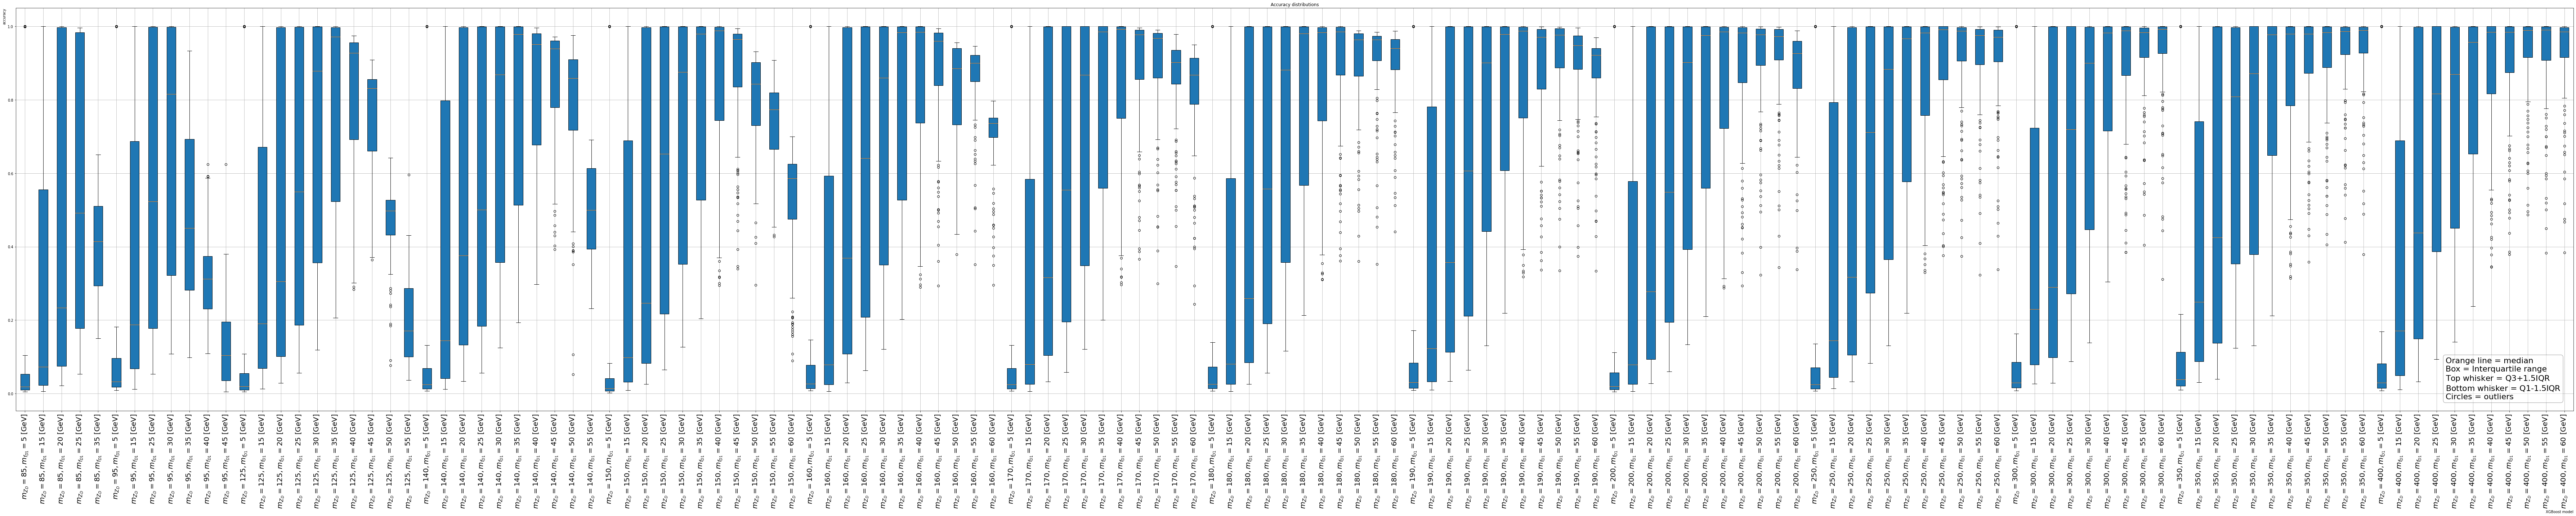

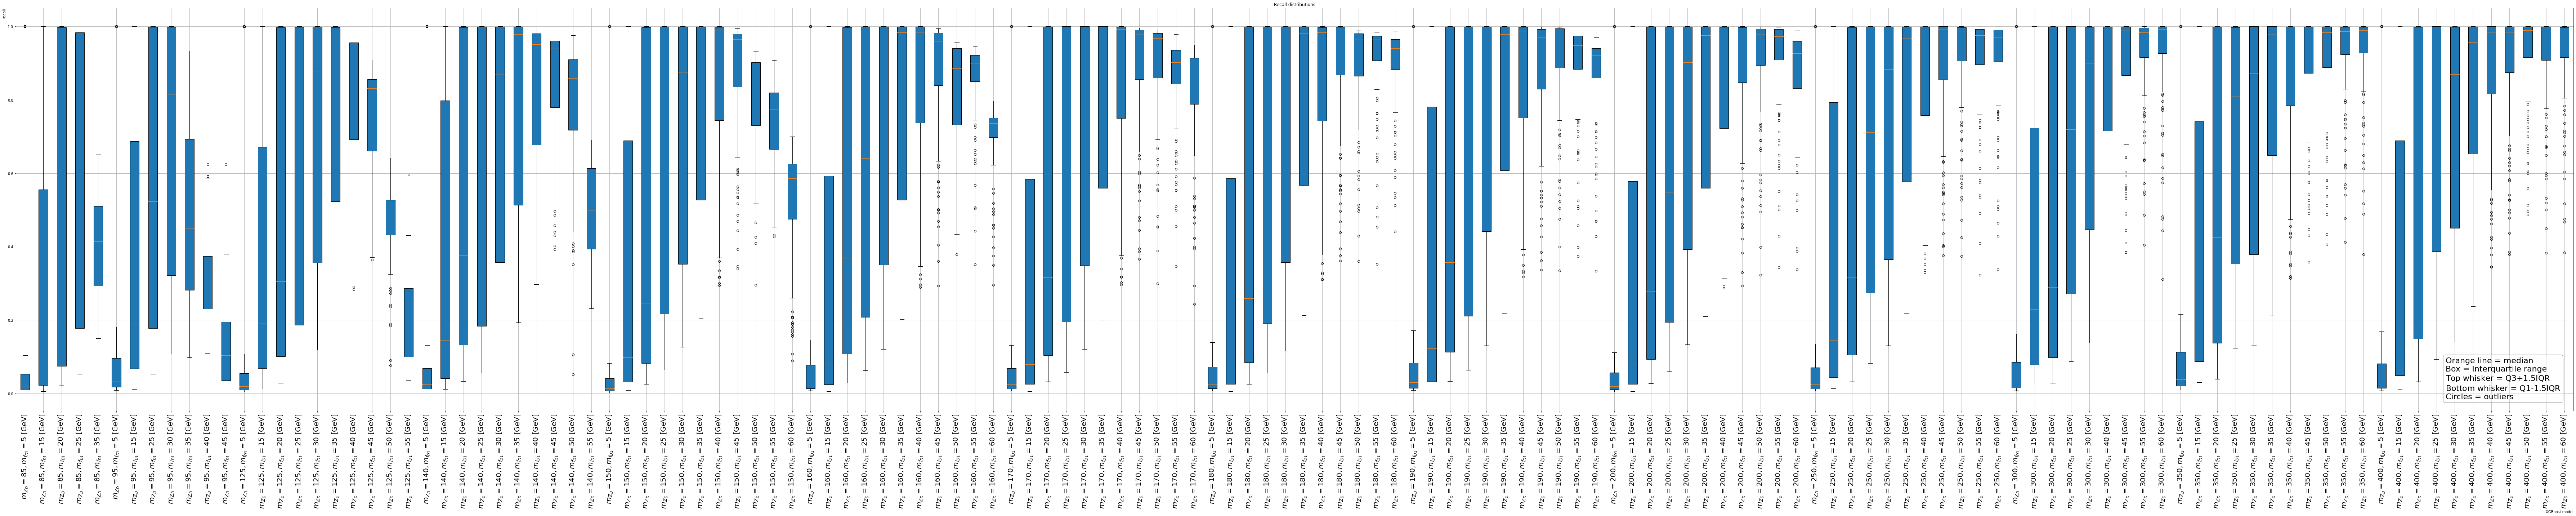

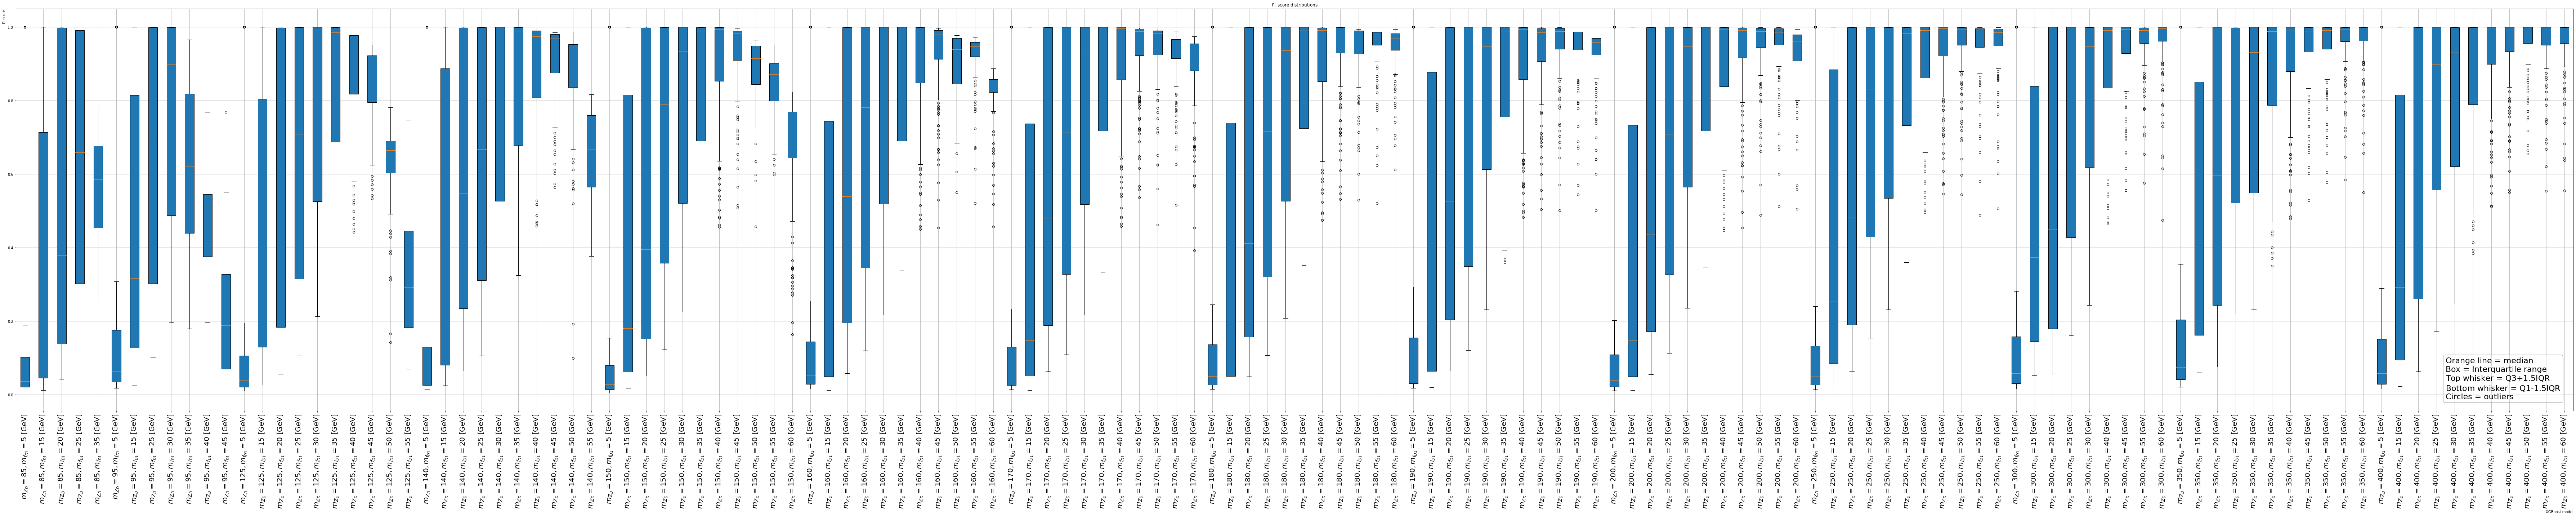

In [ ]:
base_dir = "processed_root_files_mc/all_samples_predicted_all_models/"
plt.rcParams.update({'font.size': 32}) # Increase font size for plotting
#custom_xticks = list(dist_plot_data.keys())
custom_xticks = list(model_labels.values())


for metric in dist_plot_data['MZD_250_45'].keys():
    if metric == "precision": # by definition, precision is 1
        pass
    else:
        fig, ax = plt.subplots(figsize = (100, 20))
        ax.set_title("%s distributions" % class_rep_titles[metric])
        ax.set_xlabel("XGBoost model", loc = 'right')
        ax.set_ylabel("%s" % metric, loc = 'top')
        #ax.set_ylim(0, 4)
        ax.grid()

        plt_data = []
        for model in dist_plot_data.keys():
            plt_data.append(dist_plot_data[model][metric])

        ax.boxplot(plt_data, patch_artist = True, widths = 0.5)

        #ax.text(-0.092, 1.01, 'CMS', fontweight='bold', fontsize=28, transform=ax.transAxes)
        #ax.text(0.01, 1.01, 'Preliminary',fontstyle='italic', fontsize=26, transform=ax.transAxes)
        
        plt.xticks(np.arange(1, len(dist_plot_data) + 1), custom_xticks, rotation = 90, fontsize = 20) # replace ticks with vfat number
        
        text0 = '\n'.join((
        r'Orange line = median',
        r'Box = Interquartile range', 
        r'Top whisker = Q3+$1.5\mathrm{IQR}$', 
        r'Bottom whisker = Q1-$1.5\mathrm{IQR}$',
        r'Circles = outliers'))
        props = dict(boxstyle = 'round', facecolor = 'white', alpha = 0.4)

        ax.text(0.95, 0.03, text0, transform = ax.transAxes, fontsize = 22, bbox = props)
        fig.tight_layout()
        fig.savefig(base_dir + 'test_%s.pdf' % metric)